In [1]:
import numpy as np
from scipy.stats import multivariate_normal as MVN
import matplotlib.pyplot as plt
from scipy.optimize import root, fsolve, minimize
from numpy.linalg import norm, solve, inv, det
from numpy import log, zeros, eye, exp, cos, sin, pi, diag
from scipy.stats import uniform as udist
from numpy.random import rand
from matplotlib.colors import ListedColormap
from warnings import catch_warnings, filterwarnings
from scipy.linalg import qr
from copy import deepcopy
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext

from utils import prep_contour, generate_powers_of_ten
from Manifolds.GeneralizedEllipse import GeneralizedEllipse

In [2]:
# Define constraint function
p = 10
μ = zeros(p)
diagonal = np.array([0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) #np.array([100, 100, *np.ones(p-2)])#np.concatenate((np.full(p//2, 100), np.ones(p - (p//2))))
Σ = diag(diagonal)
π = MVN(μ, Σ)
f = π.logpdf
# Ellipsoid
z0 = -23
ellipse = GeneralizedEllipse(μ, Σ, exp(z0))

In [3]:
def HugTangentialMultivariate(x0, T, B, N, α, q, logpi, jac, method='qr'):
    """Multidimensional Tangential Hug sampler. Two possible methods:
    - 'qr': projects onto row space of Jacobian using QR decomposition.
    - 'linear': solves a linear system to project.
    """
    OUT = {
#     'D' : {f"{i}": [] for i in range(N)}, # Distance
#     'SD': {f"{i}": [] for i in range(N)}, # Square Distance
    'AR': [np.nan for i in range(N)],     # Acceptance Ratio
    'Δk': [np.nan for i in range(N)],     # Kinetic Energy
    'Δℓ': [np.nan for i in range(N)],     # Potential Energy
#     'SAMPLES': x0,
    'ACCEPTANCES': np.zeros(N),
#     'EJSD': [np.nan for i in range(N)],      # Acceptance Ratio * Squared Distance
    'EJSD_AP': [np.nan for i in range(N)],    # Acceptance PROBABILITY * Squared Distance
    }
    assert method == 'qr' or method == 'linear' or method == 'lstsq'
    def qr_project(v, J):
        """Projects using QR decomposition."""
        Q, _ = qr(J.T, mode='economic')
        return Q.dot((Q.T.dot(v)))
    def linear_project(v, J):
        """Projects by solving linear system."""
        return J.T.dot(solve(J.dot(J.T), J.dot(v)))
    def lstsq_project(v, J):
        """Projects using scipy's Least Squares Routine."""
        return J.T.dot(lstsq(J.T, v)[0])
    if method == 'qr':
        project = qr_project
    elif method == 'linear':
        project = linear_project
    else:
        project = lstsq_project
    # Jacobian function raising an error for RuntimeWarning
    def safe_jac(x):
        """Raises an error when a RuntimeWarning appears."""
        while catch_warnings():
            filterwarnings('error')
            try:
                return jac(x)
            except RuntimeWarning:
                raise ValueError("Jacobian computation failed due to Runtime Warning.")
    samples, acceptances = x0, np.zeros(N)
    # Compute initial Jacobian. 
    for i in range(N):
        v0s = q.rvs()
        # Squeeze
        v0 = v0s - α * project(v0s, safe_jac(x0)) #jac(x0))
        v, x = v0, x0
        logu = np.log(rand())
        δ = T / B
        for _ in range(B):
            xmid = x + δ*v/2
            v = v - 2 * project(v, safe_jac(xmid)) #jac(x))
            x = xmid + δ*v/2
            # Compute metrics
#             OUT['D'][f"{i}"].append(norm(x - x0))
#             OUT['SD'][f"{i}"].append(norm(x  -x0)**2)
        # Unsqueeze
        v = v + (α / (1 - α)) * project(v, safe_jac(x)) #jac(x))
        # In the acceptance ratio must use spherical velocities!! Hence v0s and the unsqueezed v
        logar = logpi(x) + q.logpdf(v) - logpi(x0) - q.logpdf(v0s)
        ar = exp(logar)
        OUT['AR'][i] = ar
        OUT['Δk'][i] = - norm(v)**2 + norm(v0s)**2
        OUT['Δℓ'][i] = logpi(x) - logpi(x0)
#         OUT['EJSD'][i] = ar * (norm(x - x0)**2)
        OUT['EJSD_AP'][i] = np.clip(ar, a_min=0.0, a_max=1.0) * (norm(x - x0)**2)
        if logu <= logar:
#             OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x))
            OUT['ACCEPTANCES'][i] = 1         # Accepted!
            x0 = x
        else:
#             OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x0))
            OUT['ACCEPTANCES'][i] = 0         # Rejected
    return OUT

In [4]:
q = MVN(zeros(p), eye(p))

In [5]:
def generate_starting_points(ϵs, n_tries=10):
    x0s = np.zeros((len(ϵs), p))
    for i in range(len(ϵs)):
        j = 0
        while j <= n_tries:
            j += 1
            with catch_warnings():
                filterwarnings('error')
                try: 
                    x0 = ellipse.sample(advanced=True)
                    x0s[i, :] = x0
                    break
                except RuntimeWarning:
                    print(f"Can't find {i}th point. Trying again.")
                    continue
            if j == n_tries:
                raise ValueError("Couldn't find point.")
    return x0s

In [6]:
def generate_logpi(ϵ):
    # Kernel
#     def logkernel(xi):
#         with np.errstate(divide='ignore'):
#             return log(float(norm(f(xi) - z0) < ϵ) / ϵ)
    def logkernel(xi):
        return -norm(f(xi) - z0)**2/(2*(ϵ**2)) - np.log(ϵ)
    # Logpi
    logpi = lambda xi: logkernel(xi) #logprior(xi) + logkernel(xi)
    return logpi

def generate_output(ϵs, αs, δs, x0s, N=1000):
    OUTS = []
    for ϵix, ϵ in enumerate(ϵs):
        for αix, α in enumerate(αs):
            for δix, δ in enumerate(δs):
                logpi = generate_logpi(ϵ)
                jac = lambda xi: ellipse.Q(xi).T
                OUTS.append(HugTangentialMultivariate(x0s[ϵix], δ*B, B, N, α, q, logpi, jac))
    return OUTS

In [7]:
normalize = lambda a: a / np.nanmax(a)

In [8]:
N_GRID = 20
B = 10
αs_prelim = np.linspace(start=0.0, stop=1.0, num=N_GRID, endpoint=False)

In [9]:
x0s = generate_starting_points(np.zeros(1))

#### $\epsilon = 0.1$ but with large range of $\delta$

In [10]:
δs_eps01_large = np.geomspace(start=0.01, stop=100.0, num=N_GRID, endpoint=True)
OUT_EPS01_large = generate_output(
    ϵs=np.array([0.1]),
    αs=αs_prelim,
    δs=δs_eps01_large,
    x0s=x0s,
    N=10000
)
OUT_EJSD_AP_EPS01_large = np.zeros((len(αs_prelim), len(δs_eps01_large)))
for i in range(len(OUT_EPS01_large)):
    ix = np.unravel_index(i, (len(αs_prelim), len(δs_eps01_large)))
    OUT_EJSD_AP_EPS01_large[ix] = np.mean(OUT_EPS01_large[i]['EJSD_AP'])
δ_grid_eps01_large, α_grid_eps01_large = np.meshgrid(δs_eps01_large, αs_prelim)

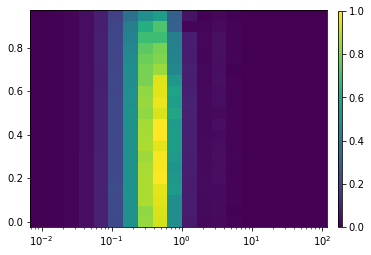

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.pcolor(δ_grid_eps01_large, α_grid_eps01_large, normalize(OUT_EJSD_AP_EPS01_large))
ax.set_xscale('log')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.98, 0.125, 0.01, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()

#### $\epsilon = 0.01$ with  large $\delta$ range

In [12]:
δs_eps001_large = np.geomspace(start=0.01, stop=100.0, num=N_GRID, endpoint=True)
OUT_EPS001_large = generate_output(
    ϵs=np.array([0.01]),
    αs=αs_prelim,
    δs=δs_eps001_large,
    x0s=x0s,
    N=10000
)
OUT_EJSD_AP_EPS001_large = np.zeros((len(αs_prelim), len(δs_eps001_large)))
for i in range(len(OUT_EPS001_large)):
    ix = np.unravel_index(i, (len(αs_prelim), len(δs_eps001_large)))
    OUT_EJSD_AP_EPS001_large[ix] = np.mean(OUT_EPS001_large[i]['EJSD_AP'])
δ_grid_eps001_large, α_grid_eps001_large = np.meshgrid(δs_eps001_large, αs_prelim)

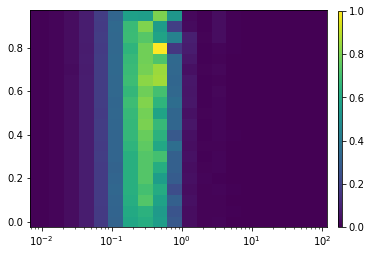

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.pcolor(δ_grid_eps001_large, α_grid_eps001_large, normalize(OUT_EJSD_AP_EPS001_large))
ax.set_xscale('log')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.98, 0.125, 0.01, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()

#### $\epsilon = 0.001$ with large range of $\delta$

In [15]:
δs_eps0001_large = np.geomspace(start=0.01, stop=100.0, num=N_GRID, endpoint=True)
OUT_EPS0001_large = generate_output(
    ϵs=np.array([0.001]),
    αs=αs_prelim,
    δs=δs_eps0001_large,
    x0s=x0s,
    N=10000
)
OUT_EJSD_AP_EPS0001_large = np.zeros((len(αs_prelim), len(δs_eps0001_large)))
for i in range(len(OUT_EPS0001_large)):
    ix = np.unravel_index(i, (len(αs_prelim), len(δs_eps0001_large)))
    OUT_EJSD_AP_EPS0001_large[ix] = np.mean(OUT_EPS0001_large[i]['EJSD_AP'])
δ_grid_eps0001_large, α_grid_eps0001_large = np.meshgrid(δs_eps0001_large, αs_prelim)

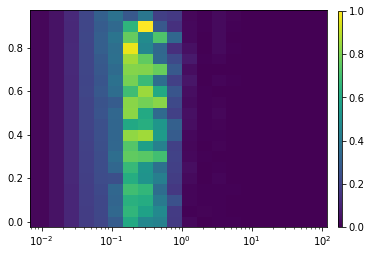

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.pcolor(δ_grid_eps0001_large, α_grid_eps0001_large, normalize(OUT_EJSD_AP_EPS0001_large))
ax.set_xscale('log')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.98, 0.125, 0.01, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()

#### $\epsilon = 0.001$ with smaller range of $\delta$

In [17]:
δs_eps0001_small = np.geomspace(start=0.05, stop=2.0, num=N_GRID, endpoint=True)
OUT_EPS0001_small = generate_output(
    ϵs=np.array([0.001]),
    αs=αs_prelim,
    δs=δs_eps0001_small,
    x0s=x0s,
    N=10000
)
OUT_EJSD_AP_EPS0001_small = np.zeros((len(αs_prelim), len(δs_eps0001_small)))
for i in range(len(OUT_EPS0001_small)):
    ix = np.unravel_index(i, (len(αs_prelim), len(δs_eps0001_small)))
    OUT_EJSD_AP_EPS0001_small[ix] = np.mean(OUT_EPS0001_small[i]['EJSD_AP'])
δ_grid_eps0001_small, α_grid_eps0001_small = np.meshgrid(δs_eps0001_small, αs_prelim)

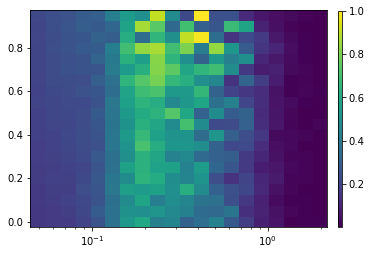

In [18]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.pcolor(δ_grid_eps0001_small, α_grid_eps0001_small, normalize(OUT_EJSD_AP_EPS0001_small))
ax.set_xscale('log')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.98, 0.125, 0.01, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()

#### $\epsilon = 0.001$ with smaller range of $\delta$ and finer grid for both $\delta$ and $\alpha$

In [20]:
N_GRID_FINER = 30
αs_eps0001_finer = np.linspace(start=0.0, stop=1.0, num=N_GRID_FINER, endpoint=False)
δs_eps0001_small_finer = np.geomspace(start=0.05, stop=2.0, num=N_GRID_FINER, endpoint=True)
OUT_EPS0001_small_finer = generate_output(
    ϵs=np.array([0.001]),
    αs=αs_eps0001_finer,
    δs=δs_eps0001_small_finer,
    x0s=x0s,
    N=10000
)
OUT_EJSD_AP_EPS0001_small_finer = np.zeros((len(αs_eps0001_finer), len(δs_eps0001_small_finer)))
for i in range(len(OUT_EPS0001_small_finer)):
    ix = np.unravel_index(i, (len(αs_eps0001_finer), len(δs_eps0001_small_finer)))
    OUT_EJSD_AP_EPS0001_small_finer[ix] = np.mean(OUT_EPS0001_small_finer[i]['EJSD_AP'])
δ_grid_eps0001_small_finer, α_grid_eps0001_small_finer = np.meshgrid(δs_eps0001_small_finer, αs_eps0001_finer)

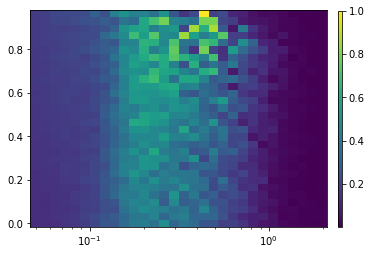

In [25]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.pcolor(δ_grid_eps0001_small_finer, α_grid_eps0001_small_finer, normalize(OUT_EJSD_AP_EPS0001_small_finer))
ax.set_xscale('log')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.98, 0.125, 0.01, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()

#### same as above, but using a new starting point

In [26]:
x0s_new = generate_starting_points(np.zeros(1))

In [29]:
N_GRID_FINER_NEW = 30
αs_eps0001_finer_new = np.linspace(start=0.0, stop=1.0, num=N_GRID_FINER_NEW, endpoint=False)
δs_eps0001_small_finer_new = np.geomspace(start=0.05, stop=2.0, num=N_GRID_FINER_NEW, endpoint=True)
OUT_EPS0001_small_finer_new = generate_output(
    ϵs=np.array([0.001]),
    αs=αs_eps0001_finer_new,
    δs=δs_eps0001_small_finer_new,
    x0s=x0s_new,
    N=15000
)
OUT_EJSD_AP_EPS0001_small_finer_new = np.zeros((len(αs_eps0001_finer_new), len(δs_eps0001_small_finer_new)))
for i in range(len(OUT_EPS0001_small_finer_new)):
    ix = np.unravel_index(i, (len(αs_eps0001_finer_new), len(δs_eps0001_small_finer_new)))
    OUT_EJSD_AP_EPS0001_small_finer_new[ix] = np.mean(OUT_EPS0001_small_finer_new[i]['EJSD_AP'])
δ_grid_eps0001_small_finer_new, α_grid_eps0001_small_finer_new = np.meshgrid(δs_eps0001_small_finer_new, αs_eps0001_finer_new)

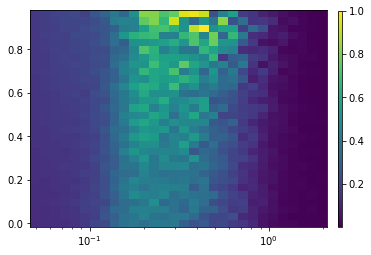

In [30]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.pcolor(δ_grid_eps0001_small_finer_new, α_grid_eps0001_small_finer_new, normalize(OUT_EJSD_AP_EPS0001_small_finer_new))
ax.set_xscale('log')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.98, 0.125, 0.01, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()